In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score
RANDOM_STATE = 42

# load data

In [185]:
X = np.load("Descriptor1_complete_features.npy")  
y = np.load("Descriptor1_complete_targets.npy")   

print(X.shape)

(1452, 147)


# class imbalance ratio

In [187]:
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples ({count/len(y):.2%})")

Class 0: 969 samples (66.74%)
Class 1: 483 samples (33.26%)


# identifying columns with >= 99 % zeros

In [190]:
# first 144 
X_eig = X[:, :144]

# how often each column is zero 
zero_rate = (X_eig == 0).mean(axis=0)
nonzero_count = (X_eig != 0).sum(axis=0)

# sorted summary (most-zero first)
order = np.argsort(-zero_rate)
summary = pd.DataFrame({
    "eig_col": order,                 # 0-based index within the 144 eig cols
    "zero_rate": zero_rate[order],
    "nonzero_count": nonzero_count[order]
})
print(summary.head(100).to_string(index=False))

# columns that are ≥99% zero
cols_99 = np.where(zero_rate >= 0.99)[0]
print("\nCols ≥99% zero (0-based):", cols_99.tolist())        #index start from 0 
#print("Cols ≥99% zero (1-based):", (cols_99 + 1).tolist())   #index start from 1 

 eig_col  zero_rate  nonzero_count
     143   0.999311              1
     128   0.999311              1
     129   0.999311              1
     130   0.999311              1
     131   0.999311              1
     132   0.999311              1
     133   0.999311              1
     134   0.999311              1
     142   0.999311              1
     136   0.999311              1
     137   0.999311              1
     138   0.999311              1
     139   0.999311              1
     140   0.999311              1
     141   0.999311              1
     135   0.999311              1
     112   0.998623              2
     113   0.998623              2
     114   0.998623              2
     115   0.998623              2
     116   0.998623              2
     117   0.998623              2
     118   0.998623              2
     121   0.998623              2
     120   0.998623              2
     122   0.998623              2
     123   0.998623              2
     124   0.998623 

# keeping top 72 + meta data (charge/spin/size)

In [192]:
# Eigenvalues + meta data 
K = 72 
X = np.hstack([X[:, :K], X[:, -3:]])

print( "Trimmed shape:", X.shape)

Trimmed shape: (1452, 75)


# train test split

In [194]:
# 20/80 split. 
# 20 % for our hold out test set 
# 80 % for hyperparam tuning, ...
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # preserve 66/34 balance
    random_state=RANDOM_STATE
)

print("Train/Val size:", X_trainval.shape[0])
print("Test size:", X_test.shape[0])

Train/Val size: 1161
Test size: 291


# XGB selecting k & params

In [ ]:
RANDOM_STATE = 42
from sklearn.metrics import make_scorer, recall_score

neg = (y_trainval == 0).sum()
pos = (y_trainval == 1).sum()
spw = neg / max(pos, 1)

K_list = [5,6,7,8,9,10,11,12,13,14,15,16, 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
# K_list = list(range(1, 73))
# K_list = [10,20,30,40,50,60,70]
K_list = [ 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
K_list = list(range(15, 73))
K_list = list(range(15, 30))
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# search space 
param_dist = {
    "n_estimators": [ 200, 300, 400, 500 ], #, 600, 800, 1000],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5],
}

# scoring metrics
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]]) #top k eigneval + 3 metadata
    xgb = XGBClassifier(random_state=RANDOM_STATE, 
                        eval_metric="logloss", 
                       scale_pos_weight=spw
                       )
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0, 
    )
    
    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,
    }
    results.append(rec)
    search_by_K[K] = search

15
16
17
18
19


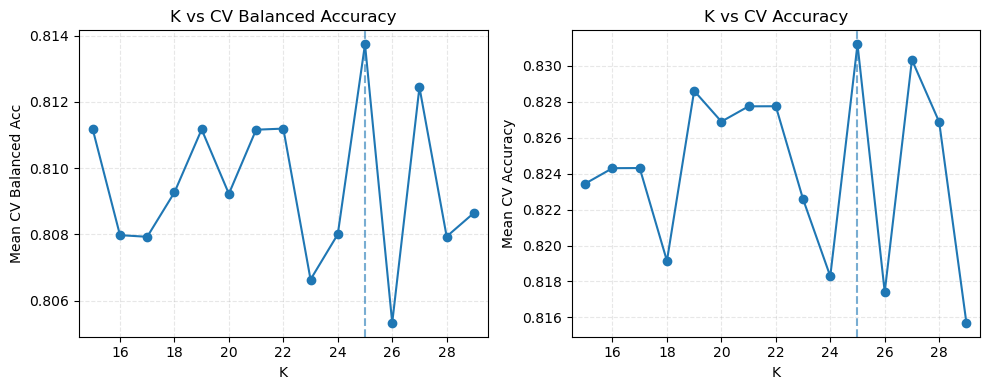

In [279]:
df = pd.DataFrame(results).sort_values("K").reset_index(drop=True)

# Best K by balanced accuracy (tie-break: acc_mean, then smaller K)
best_rec = max(df.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best_rec["K"]

# Plots: left = K vs CV Balanced Acc, right = K vs CV Accuracy (no std/error bars)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Left: balanced accuracy
axes[0].plot(df["K"], df["bal_mean"], "o-")
axes[0].axvline(K_star, linestyle="--", alpha=0.6)
axes[0].set_title("K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

# Right: accuracy
axes[1].plot(df["K"], df["acc_mean"], "o-")
axes[1].axvline(K_star, linestyle="--", alpha=0.6)
axes[1].set_title("K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")

#  x-limits to tested Ks
axes[1].set_xlim(df["K"].min() - 0.5, df["K"].max() + 0.5)

plt.tight_layout()
plt.show()

In [264]:
#  summary sorted by balanced accuracy
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# best k 
best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(best bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))


=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
 8   0.814    0.012    0.830    0.012
25   0.814    0.019    0.831    0.022
11   0.812    0.015    0.820    0.018
27   0.812    0.016    0.830    0.014
 9   0.812    0.018    0.826    0.022
22   0.811    0.017    0.828    0.019
14   0.811    0.017    0.828    0.018
15   0.811    0.011    0.823    0.018
19   0.811    0.014    0.829    0.017
21   0.811    0.014    0.828    0.016
 7   0.811    0.015    0.827    0.019
12   0.811    0.014    0.818    0.016
13   0.811    0.015    0.825    0.017
10   0.810    0.014    0.829    0.016
18   0.809    0.015    0.819    0.019
20   0.809    0.014    0.827    0.023
29   0.809    0.022    0.816    0.028
 5   0.809    0.017    0.818    0.019
 6   0.809    0.017    0.820    0.018
24   0.808    0.020    0.818    0.022
16   0.808    0.020    0.824    0.015
28   0.808    0.014    0.827    0.015
17   0.808    0.016    0.824    0.025


In [258]:
# # --- Manually set K* ---
# results.sort(key=lambda d: d["bal_mean"], reverse=True)

# print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
# print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
# for r in results:
#     print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
#           f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# # Manually choose K*
# K_star = 22
# winner = next((r for r in results if r["K"] == K_star), None)
# if winner is None:
#     raise ValueError(f"K={K_star} not found in results.")

# print(f"\n>>> Manually selected K* = {K_star} "
#       f"(bal_acc={winner['bal_mean']:.3f}±{winner['bal_std']:.3f}; "
#       f"acc_mean={winner['acc_mean']:.3f}±{winner['acc_std']:.3f})")
# print("Winner params:", winner.get("best_params"))


In [250]:
# # slightly lower cutoff at inference 

# import numpy as np
# from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score

# # 1) Pick K* the same way (by balanced accuracy, tie-break by acc, then smaller K)
# best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
# K_star = best["K"]
# best_search = search_by_K[K_star]
# best_model = best_search.best_estimator_  # already refit on all trainval folds

# # 2) Build the matching feature views for K*
# Xi_train = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
# Xi_test  = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

# #  reduce the decision cutoff 
# THRESHOLD = 0.48

# # 4) Predict with the adjusted threshold
# proba_train = best_model.predict_proba(Xi_train)[:, 1]
# y_pred_train = (proba_train >= THRESHOLD).astype(int)

# proba_test = best_model.predict_proba(Xi_test)[:, 1]
# y_pred_test = (proba_test >= THRESHOLD).astype(int)

# # 5) quick report
# print(f"K* = {K_star}, threshold = {THRESHOLD:.2f}")
# print("Train  | Acc:",
#       f"{accuracy_score(y_trainval, y_pred_train):.3f}",
#       "BalAcc:", f"{balanced_accuracy_score(y_trainval, y_pred_train):.3f}",
#       "Recall:", f"{recall_score(y_trainval, y_pred_train, zero_division=0):.3f}",
#       "Prec:",   f"{precision_score(y_trainval, y_pred_train, zero_division=0):.3f}")

# print("Test   | Acc:",
#       f"{accuracy_score(y_test, y_pred_test):.3f}",
#       "BalAcc:", f"{balanced_accuracy_score(y_test, y_pred_test):.3f}",
#       "Recall:", f"{recall_score(y_test, y_pred_test, zero_division=0):.3f}",
#       "Prec:",   f"{precision_score(y_test, y_pred_test, zero_division=0):.3f}")


K* = 22, threshold = 0.49
Train  | Acc: 0.936 BalAcc: 0.945 Recall: 0.972 Prec: 0.856
Test   | Acc: 0.825 BalAcc: 0.817 Recall: 0.794 Prec: 0.713


In [266]:
# Refit on all train/val with K* and evaluate on test 
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_xgb = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_xgb.fit(X_trainval_k, y_trainval)           #  re-fit 

# Train eval
y_pred_tr = best_xgb.predict(X_trainval_k)
y_prob_tr = best_xgb.predict_proba(X_trainval_k)[:, 1]
print("\n=== XGBoostTrain Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=3))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

y_pred_te = best_xgb.predict(X_test_k)
y_prob_te = best_xgb.predict_proba(X_test_k)[:, 1]
print("\n=== XGBoost Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=3))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))


=== XGBoostTrain Set Performance ===
              precision    recall  f1-score   support

           0      0.995     0.956     0.975       775
           1      0.918     0.990     0.953       386

    accuracy                          0.967      1161
   macro avg      0.956     0.973     0.964      1161
weighted avg      0.969     0.967     0.968      1161

Train Accuracy: 0.967269595176572
Train Balanced Acc: 0.9728831689787731
Train ROC-AUC: 0.9953668728062846
Train PR-AUC: 0.9894980878305644

=== XGBoost Test Set Performance ===
              precision    recall  f1-score   support

           0      0.884     0.866     0.875       194
           1      0.743     0.773     0.758        97

    accuracy                          0.835       291
   macro avg      0.813     0.820     0.816       291
weighted avg      0.837     0.835     0.836       291

Test Accuracy: 0.8350515463917526
Test Balanced Acc: 0.8195876288659794
Test ROC-AUC: 0.8710543097034755
Test PR-AUC: 0.8074702443

# feature importance

all features:  ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 'feat_22']

Top 20 features:
feat_19    0.2038
feat_17    0.0971
feat_18    0.0962
feat_15    0.0609
feat_21    0.0485
feat_13    0.0432
feat_22    0.0376
feat_11    0.0331
feat_20    0.0309
feat_1     0.0297
feat_12    0.0281
feat_16    0.0277
feat_7     0.0276
feat_5     0.0269
feat_14    0.0264
feat_0     0.0260
feat_6     0.0245
feat_3     0.0243
feat_4     0.0231
feat_10    0.0222
dtype: float32


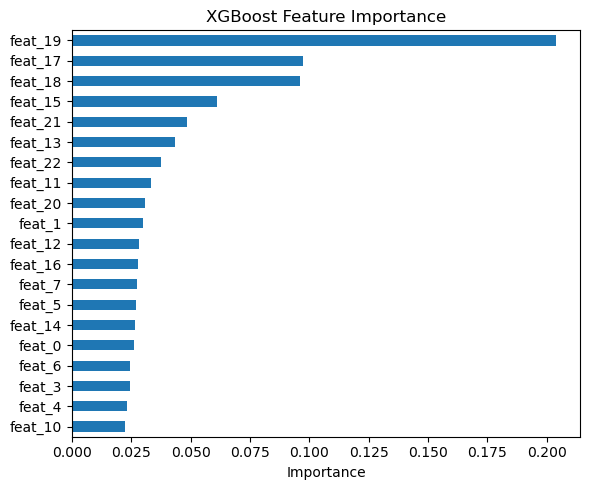

In [238]:
feat_names = [f"feat_{i}" for i in range(X_trainval_k.shape[1])]
print("all features: ", feat_names)

imp = pd.Series(best_xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

print("\nTop 20 features:")
print(imp.head(20).round(4))

plt.figure(figsize=(6,5))
imp.head(20).iloc[::-1].plot(kind="barh")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# RF selecting K & params

In [35]:
RANDOM_STATE = 42

K_list = [9,10,11]
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_dist = {                                  #add lr later
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [None, 6, 10, 14],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "bootstrap": [True],
    "class_weight": ["balanced", "balanced_subsample"],
}

# scoring 
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])  # top-K eig + 3 metadata
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )
    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,}
            
    results.append(rec)
    search_by_K[K] = search


9
10
11


In [36]:
# Print summary sorted by balanced accuracy 
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n===  rf RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd   ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

#  best k 
best = max(
    results,
    key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"])
)
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))



===  rf RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd   
11   0.796    0.018    0.823    0.014
10   0.793    0.010    0.817    0.011
 9   0.792    0.015    0.819    0.012

>>> Selected K* = 11 by BEST bal_acc (bal_acc=0.796±0.018; acc_mean=0.823±0.014)
Winner params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}


In [37]:
# Refit on all train/val with K* and evaluate on test.
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_rf = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_rf.fit(X_trainval_k, y_trainval)           # (harmless re-fit to be explicit)

# Train eval
y_pred_tr = best_rf.predict(X_trainval_k)
y_prob_tr =best_rf.predict_proba(X_trainval_k)[:, 1]
print("\n=== Train Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=3))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

# Test eval 
y_pred_te = best_rf.predict(X_test_k)
y_prob_te = best_rf.predict_proba(X_test_k)[:, 1]
print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=3))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))


=== Train Set Performance ===
              precision    recall  f1-score   support

           0      0.983     0.966     0.975       775
           1      0.935     0.966     0.950       386

    accuracy                          0.966      1161
   macro avg      0.959     0.966     0.962      1161
weighted avg      0.967     0.966     0.967      1161

Train Accuracy: 0.9664082687338501
Train Balanced Acc: 0.9663864282132709
Train ROC-AUC: 0.995059334781882
Train PR-AUC: 0.9895330355028866

=== Test Set Performance ===
              precision    recall  f1-score   support

           0      0.878     0.856     0.867       194
           1      0.725     0.763     0.744        97

    accuracy                          0.825       291
   macro avg      0.802     0.809     0.805       291
weighted avg      0.827     0.825     0.826       291

Test Accuracy: 0.8247422680412371
Test Balanced Acc: 0.8092783505154639
Test ROC-AUC: 0.8646242958869168
Test PR-AUC: 0.7947454896110828
